In [1]:
%matplotlib inline

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numdifftools
import scipy.optimize
import numpy as np
import yaml
import os
import uncertainties
import scipy.stats
import scipy.integrate
import pandas as pd
from tabulate import tabulate

In [3]:
def init_plot_style():
    """Define the rcParams for the plot. Requires matplotlib to be imported as mpl."""
    my_rc_params = {
        "xtick.direction": "out",
        "xtick.major.size": 8.0,
        "xtick.minor.size": 4.0,
        "xtick.minor.visible": True,
        "xtick.major.width": 1.2,
        "xtick.minor.width": 0.9,
        "ytick.direction": "out",
        "ytick.major.size": 8.0,
        "ytick.minor.size": 4.0,
        "ytick.minor.visible": True,
        "ytick.major.width": 1.2,
        "ytick.minor.width": 0.9,
        "errorbar.capsize": 0,
        "axes.linewidth": 1.2,
        # "font.familiy": "serif",
        "font.size": 11,
        "axes.grid": False,
        "ytick.right": False,
        "xtick.top": False
    }
    for key in my_rc_params.keys():
        mpl.rcParams[key] = my_rc_params[key]

init_plot_style()

In [4]:
def perform_fit(chi2_function, x0, calculate_covariance=True):
    """Wrapper function to perform the fit and calcuate the covariance matrix in one go.
    
    Arguments:
        chi2_function: Function to be minimized.
        x0: Starting values for the fit.
        calculate_covariance: Do or do not calculate the covariance matrix. This is often time intensive and might be disabled for debugging.
    """
    result = scipy.optimize.minimize(
        chi2_function, x0=x0,
        method='SLSQP', tol=1e-7, options={'maxiter': 1e7}
    )
    if calculate_covariance:
        result.covariance = np.linalg.inv(numdifftools.Hessian(chi2_function)(result.x)/2) 
    return result

# B to Rho

In [5]:
from eFFORT.SLBToU.BToVLNu import BToVLNuBCL
from eFFORT.utility import PDG

In [6]:
# m_V = 0.78265  # omega

In [7]:
lcsr_q2_points = np.array([
    np.array([7, 14]),  # A0
    np.array([0, 7, 14]),  # A1
    np.array([0, 7, 14]),  # A12
    np.array([0, 7, 14]),  # V
    np.array([0, 7, 14]),  # T1
    np.array([7, 14]),  # T2
    np.array([0, 7, 14]),  # T23
])

In [43]:
class Predictor:
    
    def __init__(self, bcl, lcsr_q2_points):
        self.bcl = bcl
        self.lcsr_q2_points = lcsr_q2_points
    
    def get_predictions(self, coefficients):
        self.bcl.coefficients = coefficients
        return np.array([
            *[self.bcl.A0(q2) for q2 in self.lcsr_q2_points[0]],
            *[self.bcl.A1(q2) for q2 in self.lcsr_q2_points[1]],
            *[self.bcl.A12(q2) for q2 in self.lcsr_q2_points[2]],
            *[self.bcl.V(q2) for q2 in self.lcsr_q2_points[3]],
            *[self.bcl.T1(q2) for q2 in self.lcsr_q2_points[4]],
            *[self.bcl.T2(q2) for q2 in self.lcsr_q2_points[5]],
            *[self.bcl.T23(q2) for q2 in self.lcsr_q2_points[6]],
        ])
    
    def get_theory_predictions(self, parameters, *binnings):
        """Helper function for chi2 evaluation."""
        self.bcl.V_ub = parameters[0]
        self.bcl.coefficients = parameters[1:]
        return np.array([
            [self.bcl.deltaGamma_deltaq2(l, u) *1e18  for l, u in binning] 
            for binning in binnings
        ])
    
    def get_theory_predictions_9p1(self, parameters, *binnings):
        """Helper function for chi2 evaluation for the 9+1 fit."""
        self.bcl.V_ub = parameters[0]
        self.bcl.coefficients = np.array([*np.zeros(2), *parameters[1:], *np.zeros(8)])
        return np.array([
            [self.bcl.deltaGamma_deltaq2(l, u) *1e18 for l, u in binning] 
            for binning in binnings
        ])
    
    def get_theory_predictions_9p1_at_q2_equal_0(self, parameters):
        """Helper function for chi2 evaluation for the 9+1 fit."""
        self.bcl.V_ub = parameters[0]
        self.bcl.coefficients = np.array([*np.zeros(2), *parameters[1:], *np.zeros(8)])
        return self.bcl.dGamma_dq2(1e-3) / scipy.integrate.quad(self.bcl.dGamma_dq2, self.bcl.q2min, self.bcl.q2max)[0]

    def get_theory_predictions_6p1(self, parameters, *binnings):
        """Helper function for chi2 evaluation for the 6+1 fit."""
        self.bcl.V_ub = parameters[0]
        self.bcl.coefficients = np.array([*np.zeros(2), parameters[1], parameters[2], 0, parameters[3], parameters[4], 0, parameters[5], parameters[6], 0, *np.zeros(8)])
        return np.array([
            [self.bcl.deltaGamma_deltaq2(l, u) *1e18 for l, u in binning] 
            for binning in binnings
        ])    
    
m_V = 0.77526  # rho
V_ub = 3.65e-3 
predictor_BToVLNuBCL = Predictor(BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=V_ub), lcsr_q2_points)

In [9]:
# Measurements are given as deltaGamma / deltaq2
from epsfits.measurements import BaBarBToRho, BelleBToRho

babarBToRho = BaBarBToRho()
babar_bins = babarBToRho.bins
babar_central = babarBToRho.central *1e18 
babar_covariance = babarBToRho.covariance *1e18 *1e18

belleBToRho = BelleBToRho()
belle_charged_bins = belleBToRho.charged_bins
belle_charged_central = belleBToRho.charged_central *1e18 
belle_charged_covariance = belleBToRho.charged_covariance *1e18 *1e18

belle_neutral_bins = belleBToRho.neutral_bins
belle_neutral_central = belleBToRho.neutral_central *1e18
belle_neutral_covariance = belleBToRho.neutral_covariance *1e18 *1e18

# Calculate the inverse only once, not at every optimization step
babar_inverse = np.linalg.inv(babar_covariance)
belle_inverse_charged = np.linalg.inv(belle_charged_covariance)
belle_inverse_neutral = np.linalg.inv(belle_neutral_covariance)

In [10]:
# Read in legacy spectrum
with open("../legacy_spectra/legacy_spectrum_rho.yaml", "r") as f:
    legacy_spectrum = yaml.load(f, Loader=yaml.FullLoader)
legacy_bins = np.array(legacy_spectrum["bins"])
legacy_central = np.array(legacy_spectrum["central_values"])
legacy_covariance = np.array(legacy_spectrum["covariance_matrix"])

# Calculate the inverse only once, not at every optimization step
legacy_inverse = np.linalg.inv(legacy_covariance)

legacy_inverse_varied_q2 = {}
for i in range(0, len(legacy_central) ):
    legacy_inverse_varied_q2[i] = np.linalg.inv(legacy_covariance[:i+1, :i+1])

In [11]:
# Read in LCSR calculation
lcsr_coefficients = np.load('../../eFFORT/data/B{}_LCSR_central.npy'.format("rho"))
lcsr_coefficients_cov = np.load('../../eFFORT/data/B{}_LCSR_covariance.npy'.format("rho"))

# Cut out only the relevant form factors
lcsr_coefficients_9p1 = lcsr_coefficients[2:11]
lcsr_coefficients_cov_9p1 = lcsr_coefficients_cov[2:11, 2:11]

# Calculate the inverse only once, not at every optimization step
theory_inverse = np.linalg.inv(lcsr_coefficients_cov)
theory_inverse_9p1 = np.linalg.inv(lcsr_coefficients_cov_9p1)

# Calculate the dGamma(q2=0) point
prandom = scipy.stats.multivariate_normal.rvs(mean=lcsr_coefficients, cov=lcsr_coefficients_cov, size=500)
toy = np.array([predictor_BToVLNuBCL.get_theory_predictions_9p1_at_q2_equal_0([V_ub, *pran]) for pran in prandom])
dGamma_at_q2_equal_0 = toy.mean()
dGamma_at_q2_equal_0_cov = toy.std() ** 2
dGamma_at_q2_equal_0_inverse = 1 / dGamma_at_q2_equal_0_cov

In [57]:
lcsr_coefficients_6p1 = np.delete(np.delete(np.delete(lcsr_coefficients_9p1, 8), 5), 2)
lcsr_coefficients_cov_6p1 = np.delete(np.delete(np.delete(np.delete(np.delete(np.delete(lcsr_coefficients_cov_9p1, 8, axis=0), 5, axis=0), 2, axis=0), 8, axis=1), 5, axis=1), 2, axis=1)

When sampling to determine the uncertainty for dGamma(q2=0) the distribution is not Gaussian (see histogram below). It is an issue for the cross-check, but it looks like the fit with just a single data point at dGamma(q2=0) does not converge and suffers from the same issue the data only fit is suffering. Should I invest more time to study this? I personally think that this will not work, which is sad because that would copy the B -> pi fits from [HFLAV](https://hflav-eos.web.cern.ch/hflav-eos/semi/summer16/html/ExclusiveVub/exclPilnu.html).

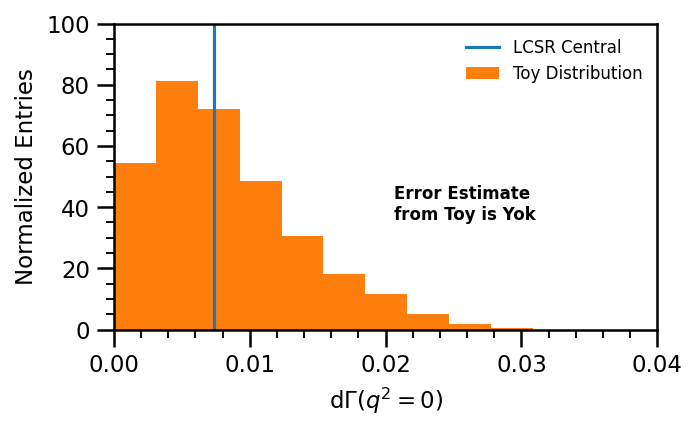

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)

ax.hist(toy, color="tab:orange", label="Toy Distribution", density=True)
ax.axvline(predictor_BToVLNuBCL.get_theory_predictions_9p1_at_q2_equal_0([V_ub, *lcsr_coefficients]), color="tab:blue", label="LCSR Central")

ax.set_xlim(0, 0.04)
ax.set_ylim(0, 100)
ax.annotate(
    'Error Estimate\nfrom Toy is Yok', (0.5, 0.5), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$\mathrm{d}\Gamma(q^2=0)$')
ax.set_ylabel(r'Normalized Entries')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

In [13]:
# Draw toy for lcsr coefficients
sample = scipy.stats.multivariate_normal.rvs(lcsr_coefficients, lcsr_coefficients_cov, size=10000)
# Generate predictions with toy
toy = np.array([predictor_BToVLNuBCL.get_predictions(x) for x in sample]).transpose()
# Correlation matrix
correlation_matrix_ff_predictions = np.corrcoef(toy)
# Covariance matrix
stds = np.array([np.std(toy[i, :]) for i in range(len(toy[:, 0]))])
theory_ff_central = predictor_BToVLNuBCL.get_predictions(lcsr_coefficients)
theory_ff_covariance = correlation_matrix_ff_predictions * np.outer(stds, stds)
theory_ff_covariance_inverse = np.linalg.inv(theory_ff_covariance)

In [14]:
# Clean up a bit
del toy
del sample

## Fit: Legacy Spectrum, 19+1

In [15]:
def chi2_wrapper(x, n_bins):
    """Chi2 function for fits to legacy spectrum.
    
    Arguments:
        x: [Vub, 19 coefficients]
        n_bins: Number of bins to be fitted to the legacy spectrum.
    """
    legacy_theory = predictor_BToVLNuBCL.get_theory_predictions(x, legacy_bins[:n_bins])
    
    theory_res = lcsr_coefficients - x[1:]
    legacy_res = legacy_central[:n_bins] - legacy_theory

    return theory_res @ theory_inverse @ np.transpose(theory_res) \
            + legacy_res @ legacy_inverse_varied_q2[n_bins-1] @ np.transpose(legacy_res)

chi2_legacy = lambda x: chi2_wrapper(x, len(legacy_central))

In [16]:
%%time
result_legacy = perform_fit(chi2_legacy, x0=np.array([V_ub, *lcsr_coefficients]))

CPU times: user 3min 27s, sys: 111 ms, total: 3min 27s
Wall time: 3min 27s


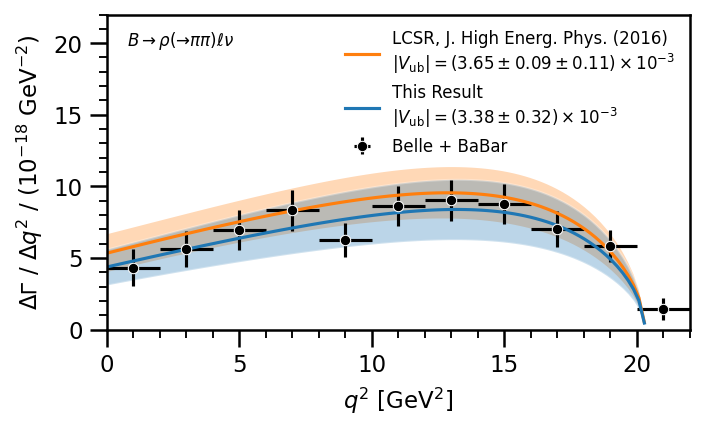

In [17]:
plotter_BToVLNuBCL = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=0)
q2 = np.linspace(plotter_BToVLNuBCL.q2min+1e-2, plotter_BToVLNuBCL.q2max-1e-2, num=100)

fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in legacy_bins],
    [c for c in legacy_central],
    yerr=[np.sqrt(legacy_covariance[i, i]) for i in range(0, len(legacy_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in legacy_bins],
    marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='black', label='Belle + BaBar'
)

# Plot HFLAV Vub + LCSR Coefficients
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(lcsr_coefficients, lcsr_coefficients_cov)
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(3.65e-3, (0.09e-3**2 + 0.11e-3**2)**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:orange", ls='solid',
        label="LCSR, J. High Energ. Phys. (2016)\n"+r"$|V_\mathrm{ub}| = (3.65 \pm 0.09 \pm 0.11) \times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:orange", alpha=0.3)

# Plot Fit Result
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(result_legacy.x[1:], result_legacy.covariance[1:, 1:])
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy.x[0], result_legacy.covariance[0, 0]**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:blue", ls='solid',
        label="This Result\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy.x[0]:.2f} \pm {1e3*result_legacy.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:blue", alpha=0.3, edgecolor="white", lw=1, ls="solid")

ax.set_xlim(0, 22)
ax.set_ylim(0, 22)
ax.annotate(
    r'$B \rightarrow \rho (\to \pi \pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'$\Delta \mathcal{\Gamma}$ / $\Delta q^2$ / ($10^{-18}$ GeV$^{-2}$)')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

In [18]:
os.makedirs("../fit_results", exist_ok=True)

with open("../fit_results/fit_result_rho.yaml", "w") as f:
    yaml.dump({
    "central_values": result_legacy.x.tolist(),
    "uncertainties": (result_legacy.covariance.diagonal()**0.5).tolist(),
    "covariance_matrix": result_legacy.covariance.tolist(),
    "correlation_matrix": (result_legacy.covariance / np.outer(result_legacy.covariance.diagonal()**0.5, result_legacy.covariance.diagonal()**0.5)).tolist()
    }, f)

## Fit: Legacy Spectrum, 19+1, use sampled Form Factors at q2={0, 7, 14}

In [19]:
def chi2_legacy_sampled_ff(x):
    legacy_theory = predictor_BToVLNuBCL.get_theory_predictions(x, legacy_bins)

    theory_res = theory_ff_central - predictor_BToVLNuBCL.get_predictions(x[1:])
    legacy_res = legacy_central - legacy_theory

    return theory_res @ theory_ff_covariance_inverse @ np.transpose(theory_res) \
            + legacy_res @ legacy_inverse @ np.transpose(legacy_res)

In [20]:
%%time
result_legacy_sampled_ff = perform_fit(chi2_legacy_sampled_ff, x0=np.array([V_ub, *lcsr_coefficients]), calculate_covariance=True)

CPU times: user 3min 29s, sys: 16 ms, total: 3min 29s
Wall time: 3min 29s


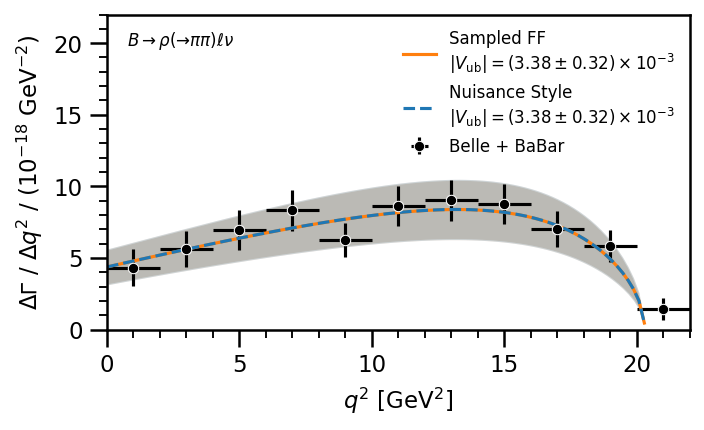

In [21]:
plotter_BToVLNuBCL = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=0)
q2 = np.linspace(plotter_BToVLNuBCL.q2min+1e-2, plotter_BToVLNuBCL.q2max-1e-2, num=100)

fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in legacy_bins],
    [c for c in legacy_central],
    yerr=[np.sqrt(legacy_covariance[i, i]) for i in range(0, len(legacy_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in legacy_bins],
    marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='black', label='Belle + BaBar'
)

# Plot HFLAV Vub + LCSR Coefficients
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(result_legacy_sampled_ff.x[1:], result_legacy_sampled_ff.covariance[1:, 1:])
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy.x[0], result_legacy_sampled_ff.covariance[0, 0]**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:orange", ls='solid',
        label="Sampled FF\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy_sampled_ff.x[0]:.2f} \pm {1e3*result_legacy_sampled_ff.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:orange", alpha=0.3, edgecolor="white", lw=1, ls="solid")
# Plot Fit Result
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(result_legacy.x[1:], result_legacy.covariance[1:, 1:])
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy.x[0], result_legacy.covariance[0, 0]**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:blue", ls='dashed',
        label="Nuisance Style\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy.x[0]:.2f} \pm {1e3*result_legacy.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:blue", alpha=0.3, edgecolor="white", lw=1, ls="solid")

ax.set_xlim(0, 22)
ax.set_ylim(0, 22)
ax.annotate(
    r'$B \rightarrow \rho (\to \pi \pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'$\Delta \mathcal{\Gamma}$ / $\Delta q^2$ / ($10^{-18}$ GeV$^{-2}$)')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

In [22]:
result_legacy_sampled_ff.x / result_legacy.x

array([1.00027   , 1.00156447, 0.99896057, 0.99932297, 0.99892754,
       0.99761433, 0.99993106, 0.99908562, 0.99358691, 0.99927187,
       1.00082423, 0.9985186 , 0.99934476, 1.00070573, 0.99941297,
       0.99912909, 0.99770086, 0.99981626, 0.99802502, 0.9939386 ])

## Fit: Legacy Spectrum, 19+1, vary q2 ranges

In [23]:
result_legacy_varied_q2_fit = {}
for i in range(0, len(legacy_central)):
    result_legacy_varied_q2_fit[i] = perform_fit(lambda x: chi2_wrapper(x, i+1), x0=np.array([V_ub, *lcsr_coefficients]), calculate_covariance=True)

## Fit: Legacy Spectrum, Vub only

In this fit the uncertainty of the LCSR coefficients is not considered. That is why the uncertainty on |Vub| is so small.

In [24]:
def chi2_legacy_vub_only1(x, n_bins):
    """Chi2 function for fits to legacy spectrum.
    
    Arguments:
        x: [Vub,]
        n_bins: Number of bins to be fitted to the legacy spectrum.
    """
    legacy_theory = predictor_BToVLNuBCL.get_theory_predictions(np.array([x, *lcsr_coefficients]), legacy_bins[:n_bins])
    legacy_res = legacy_central[:n_bins] - legacy_theory

    return legacy_res @ legacy_inverse_varied_q2[n_bins-1] @ np.transpose(legacy_res)

In [25]:
result_legacy_vub_only_varied_q2_fit = {}
for i in range(0, len(legacy_central)):
    result_legacy_vub_only_varied_q2_fit[i] = perform_fit(lambda x: chi2_legacy_vub_only1(x, i+1), x0=np.array([V_ub,]), calculate_covariance=True)

## Summary: q2 Variation

In [26]:
print("q2max \t\t BCL(19+1) \t\t\t BCL(Vub only)")
for i in range(0, len(legacy_central)):
    print(f"q2 < {legacy_bins[i][1]}  \t |Vub| = {1e3*result_legacy_varied_q2_fit[i].x[0]:.2f} +- {1e3*result_legacy_varied_q2_fit[i].covariance[0, 0]**0.5:.2f}\
    \t |Vub| = {1e3*result_legacy_vub_only_varied_q2_fit[i].x[0]:.2f} +- {1e3*result_legacy_vub_only_varied_q2_fit[i].covariance[0, 0]**0.5:.2f} ")

q2max 		 BCL(19+1) 			 BCL(Vub only)
q2 < 2  	 |Vub| = 3.16 +- 0.59    	 |Vub| = 3.16 +- 0.48 
q2 < 4  	 |Vub| = 3.28 +- 0.43    	 |Vub| = 3.27 +- 0.27 
q2 < 6  	 |Vub| = 3.38 +- 0.40    	 |Vub| = 3.35 +- 0.23 
q2 < 8  	 |Vub| = 3.50 +- 0.39    	 |Vub| = 3.44 +- 0.20 
q2 < 10  	 |Vub| = 3.32 +- 0.34    	 |Vub| = 3.32 +- 0.18 
q2 < 12  	 |Vub| = 3.34 +- 0.33    	 |Vub| = 3.34 +- 0.17 
q2 < 14  	 |Vub| = 3.37 +- 0.33    	 |Vub| = 3.36 +- 0.16 
q2 < 16  	 |Vub| = 3.39 +- 0.33    	 |Vub| = 3.39 +- 0.15 
q2 < 18  	 |Vub| = 3.39 +- 0.33    	 |Vub| = 3.39 +- 0.15 
q2 < 20  	 |Vub| = 3.38 +- 0.32    	 |Vub| = 3.40 +- 0.15 
q2 < 22  	 |Vub| = 3.38 +- 0.32    	 |Vub| = 3.40 +- 0.15 


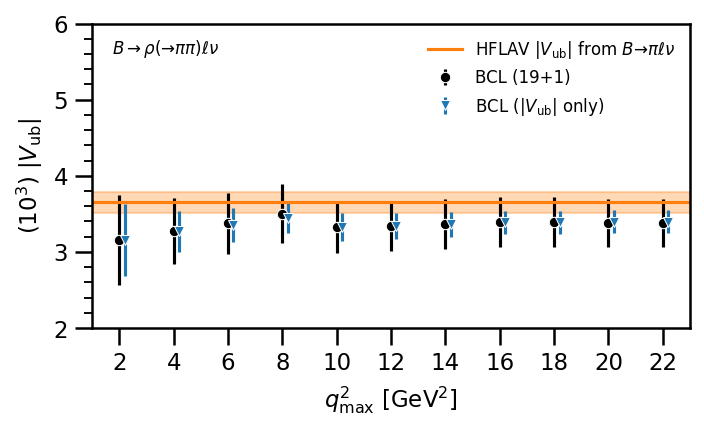

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

x = range(0, len(legacy_central))
ax.errorbar(
    x,
    [1e3 * result_legacy_varied_q2_fit[i].x[0] for i in x],
    yerr=[1e3 * result_legacy_varied_q2_fit[i].covariance[0, 0]**0.5 for i in x],
    marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='black', label='BCL (19+1)'
)

ax.errorbar(
    [tmp+0.1 for tmp in x],
    [1e3 * result_legacy_vub_only_varied_q2_fit[i].x[0] for i in x],
    yerr=[1e3 * result_legacy_vub_only_varied_q2_fit[i].covariance[0, 0]**0.5 for i in x],
    marker='v', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='tab:blue', label='BCL ($|V_\mathrm{ub}|$ only)'
)

_vub = 1e3 * uncertainties.ufloat(3.65e-3, (0.09e-3**2 + 0.11e-3**2)**0.5)

ax.axhline(_vub.nominal_value,
        color="tab:orange", ls='solid',
        # label="LCSR, J. High Energ. Phys. (2016)\n"+r"$|V_\mathrm{ub}| = (3.65 \pm 0.09 \pm 0.11) \times 10^{-3}$")
        label=r"HFLAV $|V_\mathrm{ub}|$ from $B \to \pi \ell \nu$")
ax.fill_between([min(x)-0.5, max(x)+0.5], _vub.nominal_value - _vub.std_dev, _vub.nominal_value + _vub.std_dev, alpha=0.3, color="tab:orange")

del _vub

ax.set_xlim(min(x)-0.5, max(x)+0.5)
ax.set_ylim(2, 6)
ax.annotate(
    r'$B \rightarrow \rho (\to \pi \pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 

ax.set_xticks(x, minor=False)
ax.set_xticklabels([f"{legacy_bins[i][1]}" for i in x], rotation='horizontal')
ax.tick_params(axis='x', which='minor', bottom=False)

ax.set_xlabel(r'$q^2_\mathrm{max}$ [GeV$^2$]')
ax.set_ylabel(r'$(10^3)$ $|V_\mathrm{ub}|$')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

## Fit: Individual Spectra, 19+1

In [28]:
def chi2_individual(x):
    babar_theory, belle_theory_charged, belle_theory_neutral = predictor_BToVLNuBCL.get_theory_predictions(
        x, babar_bins, belle_charged_bins, belle_neutral_bins)

    theory_res = lcsr_coefficients - x[1:]
    babar_res = babar_central - babar_theory
    belle_res_charged = belle_charged_central - belle_theory_charged
    belle_res_neutral = belle_neutral_central - belle_theory_neutral

    return theory_res @ theory_inverse @ np.transpose(theory_res) \
         + babar_res @ babar_inverse @ np.transpose(babar_res)\
         + belle_res_charged @ belle_inverse_charged @ np.transpose(belle_res_charged)\
         + belle_res_neutral @ belle_inverse_neutral @ np.transpose(belle_res_neutral)

In [29]:
%%time
result_individual = perform_fit(chi2_individual, x0=np.array([V_ub, *lcsr_coefficients]))

CPU times: user 7min 58s, sys: 16.1 ms, total: 7min 58s
Wall time: 7min 58s


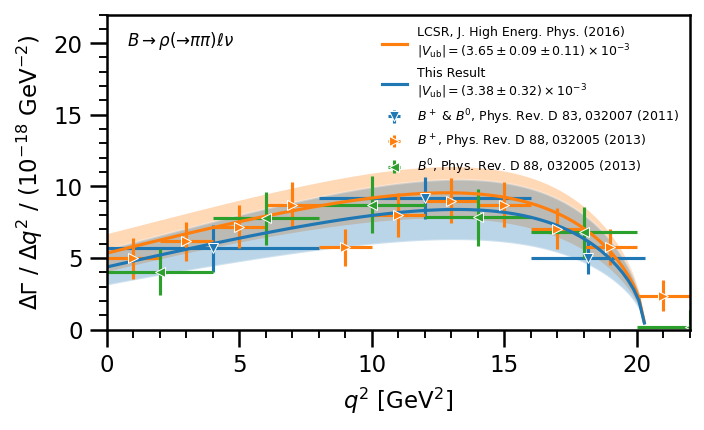

In [30]:
plotter_BToVLNuBCL = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=0)
q2 = np.linspace(plotter_BToVLNuBCL.q2min+1e-2, plotter_BToVLNuBCL.q2max-1e-2, num=100)

fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in babar_bins],
    [c for c in babar_central],
    yerr=[np.sqrt(babar_covariance[i, i]) for i in range(0, len(babar_bins))],
    xerr=[((b[1] - b[0]) / 2) for b in babar_bins],
    marker='v', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, label=r'$B^+$ & $B^0$, Phys. Rev. D 83, 032007 (2011)',
)

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in belle_charged_bins],
    [c for c in belle_charged_central],
    yerr=[np.sqrt(belle_charged_covariance[i, i]) for i in range(0, len(belle_charged_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in belle_charged_bins],
    marker='>', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, label=r'$B^+$, Phys. Rev. D 88, 032005 (2013)'
)

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in belle_neutral_bins],
    [c for c in belle_neutral_central],
    yerr=[np.sqrt(belle_neutral_covariance[i, i]) for i in range(0, len(belle_neutral_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in belle_neutral_bins],
    marker='<', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, label=r'$B^0$, Phys. Rev. D 88, 032005 (2013)'
)

# Plot HFLAV Vub + LCSR Coefficients
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(lcsr_coefficients, lcsr_coefficients_cov)
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(3.65e-3, (0.09e-3**2 + 0.11e-3**2)**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:orange", ls='solid',
        label="LCSR, J. High Energ. Phys. (2016)\n"+r"$|V_\mathrm{ub}| = (3.65 \pm 0.09 \pm 0.11) \times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:orange", alpha=0.3)

# Plot Fit Result
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(result_legacy.x[1:], result_legacy.covariance[1:, 1:])
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy.x[0], result_legacy.covariance[0, 0]**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:blue", ls='solid',
        label="This Result\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy.x[0]:.2f} \pm {1e3*result_legacy.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:blue", alpha=0.3, edgecolor="white", lw=1, ls="solid")

ax.set_xlim(0, 22)
ax.set_ylim(0, 22)
ax.annotate(
    r'$B \rightarrow \rho (\to \pi \pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'$\Delta \mathcal{\Gamma}$ / $\Delta q^2$ / ($10^{-18}$ GeV$^{-2}$)')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=6)
plt.tight_layout()
plt.show()
plt.close()

## Fit: Legacy Spectrum, 9+1

In [31]:
def chi2_legacy_9p1(x):
    legacy_theory = predictor_BToVLNuBCL.get_theory_predictions_9p1(x, legacy_bins)
    
    theory_res = lcsr_coefficients_9p1 - x[1:]
    legacy_res = legacy_central - legacy_theory

    return theory_res @ theory_inverse_9p1 @ np.transpose(theory_res) \
            + legacy_res @ legacy_inverse @ np.transpose(legacy_res)

In [32]:
%%time
result_legacy_9p1 = perform_fit(chi2_legacy_9p1, x0=np.array([V_ub, *lcsr_coefficients_9p1]))

CPU times: user 51.9 s, sys: 4 ms, total: 51.9 s
Wall time: 51.9 s


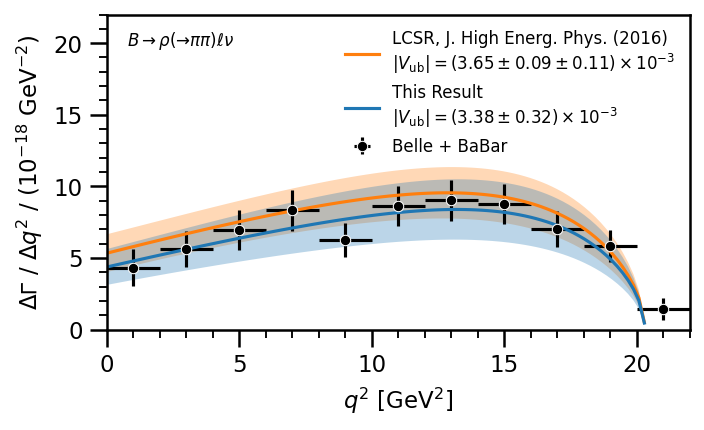

In [33]:
plotter_BToVLNuBCL = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=0)
q2 = np.linspace(plotter_BToVLNuBCL.q2min+1e-2, plotter_BToVLNuBCL.q2max-1e-2, num=100)

fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in legacy_bins],
    [c for c in legacy_central],
    yerr=[np.sqrt(legacy_covariance[i, i]) for i in range(0, len(legacy_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in legacy_bins],
    marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='black', label='Belle + BaBar'
)

# Plot HFLAV Vub + LCSR Coefficients
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(lcsr_coefficients, lcsr_coefficients_cov)
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(3.65e-3, (0.09e-3**2 + 0.11e-3**2)**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:orange", ls='solid',
        label="LCSR, J. High Energ. Phys. (2016)\n"+r"$|V_\mathrm{ub}| = (3.65 \pm 0.09 \pm 0.11) \times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:orange", alpha=0.3)

# Create padded vectors so the class can handle it
coefficients = np.array([*np.zeros(2), *result_legacy_9p1.x[1:], *np.zeros(8)])
coefficients_cov = np.zeros(lcsr_coefficients_cov.shape)
coefficients_cov[2:11, 2:11] = result_legacy_9p1.covariance[1:, 1:]

# Plot Fit Result
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(coefficients, coefficients_cov)
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy_9p1.x[0], result_legacy_9p1.covariance[0, 0]**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:blue", ls='solid',
        label="This Result\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy_9p1.x[0]:.2f} \pm {1e3*result_legacy_9p1.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:blue", alpha=0.3)

ax.set_xlim(0, 22)
ax.set_ylim(0, 22)
ax.annotate(
    r'$B \rightarrow \rho (\to \pi \pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'$\Delta \mathcal{\Gamma}$ / $\Delta q^2$ / ($10^{-18}$ GeV$^{-2}$)')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

## Fit: Legacy Spectrum, 9+1, with dGamma(q2=0)

In [34]:
def chi2_legacy_9p1_dGamma0(x):
    legacy_theory = predictor_BToVLNuBCL.get_theory_predictions_9p1(x, legacy_bins)
    dGamma_at_q2_equal_0_theory = predictor_BToVLNuBCL.get_theory_predictions_9p1_at_q2_equal_0(x)
    
    theory_res = dGamma_at_q2_equal_0 - dGamma_at_q2_equal_0_theory
    legacy_res = legacy_central - legacy_theory

    return theory_res * dGamma_at_q2_equal_0_inverse * theory_res \
            + legacy_res @ legacy_inverse @ np.transpose(legacy_res)

In [35]:
%%time
result_legacy_9p1_dGamma0 = perform_fit(chi2_legacy_9p1_dGamma0, x0=np.array([V_ub, *lcsr_coefficients_9p1]))

CPU times: user 1min 47s, sys: 12.1 ms, total: 1min 47s
Wall time: 1min 47s


[ 3.77046593e+06 -4.74302826e+05  4.90090508e+04  1.56336917e+03
  1.14970636e+01  6.79585056e+00  6.43319811e-01  1.42414163e-09
  4.56926903e-02  1.08504927e-02]
[ 1.42889547e-05 -3.12060841e+01  1.14227395e+04  4.09576037e+05
  7.12087573e+00 -1.82516336e+04 -4.52021359e+05  5.29654266e+02
  1.01299612e+05  3.29422355e+06]


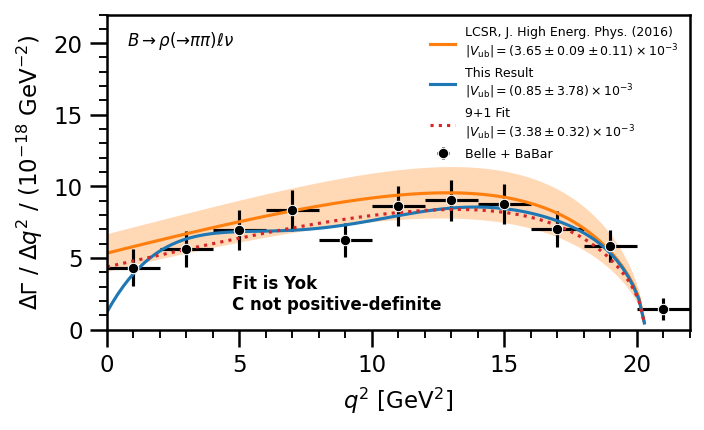

In [36]:
plotter_BToVLNuBCL = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=0)
q2 = np.linspace(plotter_BToVLNuBCL.q2min+1e-2, plotter_BToVLNuBCL.q2max-1e-2, num=100)

fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in legacy_bins],
    [c for c in legacy_central],
    yerr=[np.sqrt(legacy_covariance[i, i]) for i in range(0, len(legacy_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in legacy_bins],
    marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='black', label='Belle + BaBar'
)

# Plot HFLAV Vub + LCSR Coefficients
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(lcsr_coefficients, lcsr_coefficients_cov)
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(3.65e-3, (0.09e-3**2 + 0.11e-3**2)**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:orange", ls='solid',
        label="LCSR, J. High Energ. Phys. (2016)\n"+r"$|V_\mathrm{ub}| = (3.65 \pm 0.09 \pm 0.11) \times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:orange", alpha=0.3)

# Plot Fit Result
if (np.linalg.eigvals(result_legacy_9p1_dGamma0.covariance) > 0).all():
    # Create padded vectors so the class can handle it
    coefficients = np.array([*np.zeros(2), *result_legacy_9p1_dGamma0.x[1:], *np.zeros(8)])
    coefficients_cov = np.zeros(lcsr_coefficients_cov.shape)
    coefficients_cov[2:11, 2:11] = result_legacy_9p1_dGamma0.covariance[1:, 1:]
    
    plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(coefficients, coefficients_cov)
    plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy_9p1_dGamma0.x[0], result_legacy_9p1_dGamma0.covariance[0, 0]**0.5)
    ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
            color="tab:blue", ls='solid',
            label="This Result\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy_9p1_dGamma0.x[0]:.2f} \pm {1e3*result_legacy_9p1_dGamma0.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
    ax.fill_between(q2,
                    [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                    [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                    facecolor="tab:blue", alpha=0.3, edgecolor="black", lw=1, ls="solid")
else:
    print(np.linalg.eigvals(result_legacy_9p1_dGamma0.covariance))
    print(result_legacy_9p1_dGamma0.covariance.diagonal())
    # Create padded vectors so the class can handle it
    coefficients = np.array([*np.zeros(2), *result_legacy_9p1_dGamma0.x[1:], *np.zeros(8)])
    plotter_BToVLNuBCL.coefficients = coefficients
    plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy_9p1_dGamma0.x[0], result_legacy_9p1_dGamma0.covariance[0, 0]**0.5)
    ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
            color="tab:blue", ls='solid',
            label="This Result\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy_9p1_dGamma0.x[0]:.2f} \pm {1e3*result_legacy_9p1_dGamma0.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
    ax.annotate(
        'Fit is Yok\nC not positive-definite', (0.2, 0.2), xytext=(4, -4), xycoords='axes fraction',
        textcoords='offset points',
        fontweight='bold', ha='left', va='top', fontsize=8
    ) 

    
# Just a cross check
coefficients = np.array([*np.zeros(2), *result_legacy_9p1.x[1:], *np.zeros(8)])
coefficients_cov = np.zeros(lcsr_coefficients_cov.shape)
coefficients_cov[2:11, 2:11] = result_legacy_9p1.covariance[1:, 1:]
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(coefficients, coefficients_cov)
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy_9p1.x[0], result_legacy_9p1.covariance[0, 0]**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:red", ls='dotted',
        label="9+1 Fit\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy_9p1.x[0]:.2f} \pm {1e3*result_legacy_9p1.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
    
ax.set_xlim(0, 22)
ax.set_ylim(0, 22)
ax.annotate(
    r'$B \rightarrow \rho (\to \pi \pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'$\Delta \mathcal{\Gamma}$ / $\Delta q^2$ / ($10^{-18}$ GeV$^{-2}$)')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=6)
plt.tight_layout()
plt.show()
plt.close()

## Fit: Legacy Spectrum, 9+1, Data Only

In [37]:
def chi2_legacy_9p1_data_only(x):
    legacy_theory = predictor_BToVLNuBCL.get_theory_predictions_9p1(x, legacy_bins)
    
    legacy_res = legacy_central - legacy_theory
    
    return legacy_res @ legacy_inverse @ np.transpose(legacy_res)

In [38]:
%%time
result_legacy_9p1_data_only = scipy.optimize.minimize(  # Refactor into perform_fit. Keep as is as long as playing around with options
    chi2_legacy_9p1_data_only, x0=np.array([V_ub, *lcsr_coefficients_9p1]) / 2,
    method='SLSQP', tol=1e-7, options={'maxiter': 1e7},
    # bounds=((result_legacy_9p1.x[0]-1e-7, result_legacy_9p1.x[0]+1e-7), *[(mean - 3*std, mean + 3*std) for mean, std in zip(lcsr_coefficients_9p1, lcsr_coefficients_cov_9p1.diagonal()**0.5)]), 
)
result_legacy_9p1_data_only.covariance = np.linalg.inv(numdifftools.Hessian(chi2_legacy_9p1_data_only)(result_legacy_9p1_data_only.x)/2) 

CPU times: user 1min 15s, sys: 23.9 ms, total: 1min 15s
Wall time: 1min 15s


[-5.98557990e+05 -5.94851886e+04  4.68972370e+04  9.03974560e+02
  2.29063623e+02  3.31119268e+00  1.75458859e-02  5.85924295e-09
  1.10253358e-03  4.59281161e-03]
[ 2.36528540e-05 -1.22877095e+02 -1.71982834e+04 -1.24975901e+05
  1.62415906e+00 -1.36357584e+03 -5.40520402e+04  3.54333396e+01
 -2.06474721e+04 -3.91686477e+05]


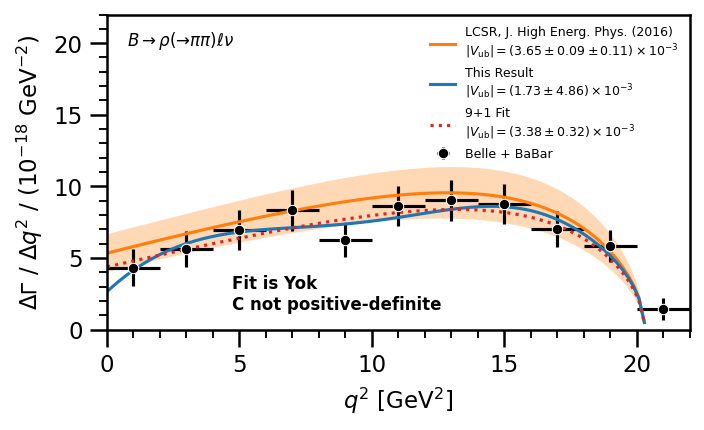

In [39]:
plotter_BToVLNuBCL = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=0)
q2 = np.linspace(plotter_BToVLNuBCL.q2min+1e-2, plotter_BToVLNuBCL.q2max-1e-2, num=100)

fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in legacy_bins],
    [c for c in legacy_central],
    yerr=[np.sqrt(legacy_covariance[i, i]) for i in range(0, len(legacy_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in legacy_bins],
    marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='black', label='Belle + BaBar'
)

# Plot HFLAV Vub + LCSR Coefficients
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(lcsr_coefficients, lcsr_coefficients_cov)
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(3.65e-3, (0.09e-3**2 + 0.11e-3**2)**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:orange", ls='solid',
        label="LCSR, J. High Energ. Phys. (2016)\n"+r"$|V_\mathrm{ub}| = (3.65 \pm 0.09 \pm 0.11) \times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:orange", alpha=0.3)

# Plot Fit Result
if (np.linalg.eigvals(result_legacy_9p1_data_only.covariance) > 0).all():
    # Create padded vectors so the class can handle it
    coefficients = np.array([*np.zeros(2), *result_legacy_9p1_data_only.x[1:], *np.zeros(8)])
    coefficients_cov = np.zeros(lcsr_coefficients_cov.shape)
    coefficients_cov[2:11, 2:11] = result_legacy_9p1_data_only.covariance[1:, 1:]
    
    plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(coefficients, coefficients_cov)
    plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy_9p1_data_only.x[0], result_legacy_9p1_data_only.covariance[0, 0]**0.5)
    ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
            color="tab:blue", ls='solid',
            label="This Result\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy_9p1_data_only.x[0]:.2f} \pm {1e3*result_legacy_9p1_data_only.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
    ax.fill_between(q2,
                    [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                    [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                    facecolor="tab:blue", alpha=0.3, edgecolor="black", lw=1, ls="solid")
else:
    print(np.linalg.eigvals(result_legacy_9p1_data_only.covariance))
    print(result_legacy_9p1_data_only.covariance.diagonal())
    # Create padded vectors so the class can handle it
    coefficients = np.array([*np.zeros(2), *result_legacy_9p1_data_only.x[1:], *np.zeros(8)])
    plotter_BToVLNuBCL.coefficients = coefficients
    plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy_9p1_data_only.x[0], result_legacy_9p1_data_only.covariance[0, 0]**0.5)
    ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
            color="tab:blue", ls='solid',
            label="This Result\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy_9p1_data_only.x[0]:.2f} \pm {1e3*result_legacy_9p1_data_only.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
    ax.annotate(
        'Fit is Yok\nC not positive-definite', (0.2, 0.2), xytext=(4, -4), xycoords='axes fraction',
        textcoords='offset points',
        fontweight='bold', ha='left', va='top', fontsize=8
    ) 

    
# Just a cross check
coefficients = np.array([*np.zeros(2), *result_legacy_9p1.x[1:], *np.zeros(8)])
coefficients_cov = np.zeros(lcsr_coefficients_cov.shape)
coefficients_cov[2:11, 2:11] = result_legacy_9p1.covariance[1:, 1:]
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(coefficients, coefficients_cov)
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy_9p1.x[0], result_legacy_9p1.covariance[0, 0]**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:red", ls='dotted',
        label="9+1 Fit\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy_9p1.x[0]:.2f} \pm {1e3*result_legacy_9p1.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
    
ax.set_xlim(0, 22)
ax.set_ylim(0, 22)
ax.annotate(
    r'$B \rightarrow \rho (\to \pi \pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'$\Delta \mathcal{\Gamma}$ / $\Delta q^2$ / ($10^{-18}$ GeV$^{-2}$)')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=6)
plt.tight_layout()
plt.show()
plt.close()

## Fit: Legacy Spectrum, 6+1, Data Only

In [59]:
def chi2_legacy_6p1_data_only(x):
    legacy_theory = predictor_BToVLNuBCL.get_theory_predictions_6p1(x, legacy_bins)
    
    legacy_res = legacy_central - legacy_theory
    
    return legacy_res @ legacy_inverse @ np.transpose(legacy_res)

In [60]:
%%time
result_legacy_6p1 = perform_fit(chi2_legacy_6p1_data_only, x0=np.array([V_ub, *lcsr_coefficients_6p1]))

CPU times: user 46 s, sys: 15.6 ms, total: 46 s
Wall time: 46 s


[-1.32451143e+03  4.25134908e+02  4.88427004e+01  9.20752799e+00
  3.27638630e-02  4.72544985e-09  1.25964941e-03]
[ 3.67758011e-05 -1.23998558e+01  6.23010338e+01  5.93188400e+00
 -8.70853764e+02  2.42943122e+01 -5.05659127e+01]


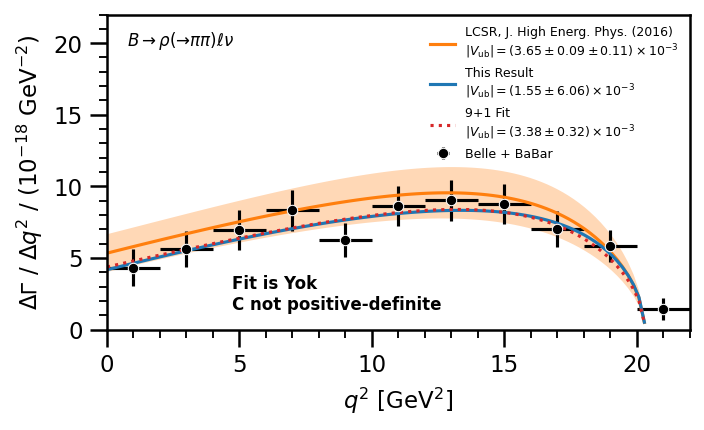

In [64]:
plotter_BToVLNuBCL = BToVLNuBCL(m_B=PDG.m_Bzero, m_V=m_V, m_L=0, V_ub=0)
q2 = np.linspace(plotter_BToVLNuBCL.q2min+1e-2, plotter_BToVLNuBCL.q2max-1e-2, num=100)

fig, ax = plt.subplots(1, 1, figsize=(3*1.61, 3), dpi=150)
lw=1.5
markersize=5

ax.errorbar(
    [(b[1] - (b[1] - b[0]) / 2) for b in legacy_bins],
    [c for c in legacy_central],
    yerr=[np.sqrt(legacy_covariance[i, i]) for i in range(0, len(legacy_covariance))],
    xerr=[((b[1] - b[0]) / 2) for b in legacy_bins],
    marker='o', markersize=markersize, markeredgecolor='white', markeredgewidth=0.5,
    ls='', lw=lw, color='black', label='Belle + BaBar'
)

# Plot HFLAV Vub + LCSR Coefficients
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(lcsr_coefficients, lcsr_coefficients_cov)
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(3.65e-3, (0.09e-3**2 + 0.11e-3**2)**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:orange", ls='solid',
        label="LCSR, J. High Energ. Phys. (2016)\n"+r"$|V_\mathrm{ub}| = (3.65 \pm 0.09 \pm 0.11) \times 10^{-3}$")
ax.fill_between(q2,
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                facecolor="tab:orange", alpha=0.3)

# Plot Fit Result
if (np.linalg.eigvals(result_legacy_6p1.covariance) > 0).all():
    # Create padded vectors so the class can handle it
    coefficients = np.array([*np.zeros(2), result_legacy_6p1.x[1], result_legacy_6p1.x[2], 0, result_legacy_6p1.x[3], result_legacy_6p1.x[4], 0, result_legacy_6p1.x[5], result_legacy_6p1.x[6], 0, *np.zeros(8)])
    coefficients_cov = np.zeros(lcsr_coefficients_cov.shape)
    coefficients_cov[2:11, 2:11] = result_legacy_6p1.covariance[1:, 1:]
    assert False  # Fix the covariance assignment if the fit should ever work
    
    plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(coefficients, coefficients_cov)
    plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy_6p1.x[0], result_legacy_6p1.covariance[0, 0]**0.5)
    ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
            color="tab:blue", ls='solid',
            label="This Result\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy_6p1.x[0]:.2f} \pm {1e3*result_legacy_6p1.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
    ax.fill_between(q2,
                    [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) - uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                    [(uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) + uncertainties.std_dev(plotter_BToVLNuBCL.dGamma_dq2(q2))) *1e18 for q2 in q2],
                    facecolor="tab:blue", alpha=0.3, edgecolor="black", lw=1, ls="solid")
else:
    print(np.linalg.eigvals(result_legacy_6p1.covariance))
    print(result_legacy_6p1.covariance.diagonal())
    # Create padded vectors so the class can handle it
    coefficients = np.array([*np.zeros(2), result_legacy_6p1.x[1], result_legacy_6p1.x[2], 0, result_legacy_6p1.x[3], result_legacy_6p1.x[4], 0, result_legacy_6p1.x[5], result_legacy_6p1.x[6], 0, *np.zeros(8)])
    plotter_BToVLNuBCL.coefficients = coefficients
    plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy_6p1.x[0], result_legacy_6p1.covariance[0, 0]**0.5)
    ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
            color="tab:blue", ls='solid',
            label="This Result\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy_6p1.x[0]:.2f} \pm {1e3*result_legacy_6p1.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
    ax.annotate(
        'Fit is Yok\nC not positive-definite', (0.2, 0.2), xytext=(4, -4), xycoords='axes fraction',
        textcoords='offset points',
        fontweight='bold', ha='left', va='top', fontsize=8
    ) 

    
# Just a cross check
coefficients = np.array([*np.zeros(2), *result_legacy_9p1.x[1:], *np.zeros(8)])
coefficients_cov = np.zeros(lcsr_coefficients_cov.shape)
coefficients_cov[2:11, 2:11] = result_legacy_9p1.covariance[1:, 1:]
plotter_BToVLNuBCL.coefficients = uncertainties.correlated_values(coefficients, coefficients_cov)
plotter_BToVLNuBCL.V_ub = uncertainties.ufloat(result_legacy_9p1.x[0], result_legacy_9p1.covariance[0, 0]**0.5)
ax.plot(q2, [uncertainties.nominal_value(plotter_BToVLNuBCL.dGamma_dq2(q2)) *1e18 for q2 in q2], 
        color="tab:red", ls='dotted',
        label="9+1 Fit\n" + r"$|V_\mathrm{ub}| = " + f"({1e3*result_legacy_9p1.x[0]:.2f} \pm {1e3*result_legacy_9p1.covariance[0, 0]**0.5:.2f})" + r"\times 10^{-3}$")
    
ax.set_xlim(0, 22)
ax.set_ylim(0, 22)
ax.annotate(
    r'$B \rightarrow \rho (\to \pi \pi) \ell \nu$', (0.02, 0.98), xytext=(4, -4), xycoords='axes fraction',
    textcoords='offset points',
    fontweight='bold', ha='left', va='top', fontsize=8
) 
ax.set_xlabel(r'$q^2$ [GeV$^2$]')
ax.set_ylabel(r'$\Delta \mathcal{\Gamma}$ / $\Delta q^2$ / ($10^{-18}$ GeV$^{-2}$)')
ax.legend(loc=1, ncol=1, frameon=False, fontsize=6)
plt.tight_layout()
plt.show()
plt.close()

## Summary: Cross-Checks

In [40]:
# label
parameter_labels = [
    r'$|V_\mathrm{ub}|$',
    r'$\alpha_1^{A_0}$', r'$\alpha_2^{A_0}$',
    r'$\alpha_0^{A_1}$', r'$\alpha_1^{A_1}$', r'$\alpha_2^{A_1}$',
    r'$\alpha_0^{A_{12}}$', r'$\alpha_1^{A_{12}}$', r'$\alpha_2^{A_{12}}$',
    r'$\alpha_0^{V}$', r'$\alpha_1^{V}$', r'$\alpha_2^{V}$',
    r'$\alpha_1^{T_1}$', r'$\alpha_2^{T_1}$',
    r'$\alpha_0^{T_2}$', r'$\alpha_1^{T_2}$', r'$\alpha_2^{T_2}$',
    r'$\alpha_0^{T_{23}}$', r'$\alpha_1^{T_{23}}$', r'$\alpha_2^{T_{23}}$',
]

# _lcsr_hflav
_central = np.array([3.65e-3, *lcsr_coefficients])
_cov = np.zeros(result_legacy.covariance.shape)
_cov[1:, 1:] = lcsr_coefficients_cov
_cov[0, 0] = (0.09e-3**2 + 0.11e-3**2)
_lcsr_hflav = uncertainties.correlated_values(_central, _cov)

# _result_legacy
_result_legacy = uncertainties.correlated_values(result_legacy.x, result_legacy.covariance)

# _result_individual
_result_individual = uncertainties.correlated_values(result_individual.x, result_individual.covariance)

# _result_legacy_9p1
_central = np.array([result_legacy_9p1.x[0], *np.zeros(2), *result_legacy_9p1.x[1:], *np.zeros(8)])
_cov = np.zeros(result_legacy.covariance.shape)
_cov[3:12, 3:12] = result_legacy_9p1.covariance[1:, 1:]
_cov[0, :] = np.array([result_legacy_9p1.covariance[0, 0], *np.zeros(2), *result_legacy_9p1.covariance[0, 1:], *np.zeros(8)])
_cov[:, 0] = _cov[0, :]
_result_legacy_9p1 = uncertainties.correlated_values(_central, _cov)

# _result_legacy_9p1_dGamma0
_central = np.array([result_legacy_9p1_dGamma0.x[0], *np.zeros(2), *result_legacy_9p1_dGamma0.x[1:], *np.zeros(8)])
_result_legacy_9p1_dGamma0 = _central
# _cov = np.zeros(result_legacy.covariance.shape)
# _cov[3:12, 3:12] = result_legacy_9p1_dGamma0.covariance[1:, 1:]
# _cov[0, :] = np.array([result_legacy_9p1_dGamma0.covariance[0, 0], *np.zeros(2), *result_legacy_9p1_dGamma0.covariance[0, 1:], *np.zeros(8)])
# _cov[:, 0] = _cov[0, :]
# _result_legacy_9p1_dGamma0 = uncertainties.correlated_values(_central, _cov)

# _result_legacy_9p1_data_only
_central = np.array([result_legacy_9p1_data_only.x[0], *np.zeros(2), *result_legacy_9p1_data_only.x[1:], *np.zeros(8)])
_result_legacy_9p1_data_only = _central
# _cov = np.zeros(result_legacy.covariance.shape)
# _cov[3:12, 3:12] = result_legacy_9p1.covariance[1:, 1:]
# _cov[0, :] = np.array([result_legacy_9p1.covariance[0, 0], *np.zeros(2), *result_legacy_9p1.covariance[0, 1:], *np.zeros(8)])
# _cov[:, 0] = _cov[0, :]
# _result_legacy_9p1 = uncertainties.correlated_values(_central, _cov)

In [41]:
_result = pd.DataFrame.from_dict({
    "label": parameter_labels,
    "_lcsr_hflav": _lcsr_hflav,
    "_result_legacy": _result_legacy,
    "_result_individual": _result_individual,
    "_result_legacy_9p1": _result_legacy_9p1,
    "_result_legacy_9p1_dGamma0": _result_legacy_9p1_dGamma0,
    "_result_legacy_9p1_data_only": _result_legacy_9p1_data_only,
})

In [42]:
print(tabulate(_result, headers=_result.columns, showindex=False, tablefmt="latex_raw"))

\begin{tabular}{lllllrr}
\hline
 label               & _lcsr_hflav       & _result_legacy    & _result_individual   & _result_legacy_9p1   &   _result_legacy_9p1_dGamma0 &   _result_legacy_9p1_data_only \\
\hline
 $|V_\mathrm{ub}|$   & 0.00365+/-0.00014 & 0.00338+/-0.00032 & 0.00339+/-0.00032    & 0.00338+/-0.00032    &                  0.000852216 &                      0.0017275 \\
 $\alpha_1^{A_0}$    & -0.83+/-0.20      & -0.87+/-0.19      & -0.86+/-0.19         & 0.0+/-0              &                  0           &                      0         \\
 $\alpha_2^{A_0}$    & 1.3+/-1.0         & 1.5+/-1.0         & 1.4+/-1.0            & 0.0+/-0              &                  0           &                      0         \\
 $\alpha_0^{A_1}$    & 0.262+/-0.026     & 0.266+/-0.025     & 0.265+/-0.025        & 0.266+/-0.025        &                  0.213589    &                     -0.173633  \\
 $\alpha_1^{A_1}$    & 0.39+/-0.14       & 0.37+/-0.13       & 0.38+/-0.13          & 0.37+

# B to Omega